# Audio Detector

In [1]:
import os
import time
import numpy as np

import sounddevice as sd
import scipy.io.wavfile as wav

import matplotlib.pyplot as plt
from IPython.display import Audio, display
import librosa.display
plt.rcParams['figure.figsize'] = (10, 4)

import tensorflow as tf

In [2]:
# Import model

model = tf.keras.models.load_model(os.getcwd() + '/audio_detector_model')

In [3]:
# Countdown timer

def countdown_timer(duration):
    while duration > 0:
        print(duration)
        time.sleep(1)
        duration -= 1
    return "Finished recording."

In [4]:
# Record a number 0-9 and display spectrogram

def record_audio(output_file, duration=3, sample_rate=44100):
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.int16)
    
    print("Say a number between 0 and 9...")
    print(countdown_timer(duration))
    
    sd.wait()
    wav.write(output_file, sample_rate, recording)
    print(f"Audio saved to {output_file}")
    
    audio_path = os.getcwd() + '/recorded_audio.wav'

    display(Audio(audio_path))
    y, sr = librosa.load(audio_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram (Speaker: User)')
    plt.show()

Would you like to record a number between 0 and 9? Enter y/n: y


Say a number between 0 and 9...
3
2
1
Finished recording.
Audio saved to recorded_audio.wav


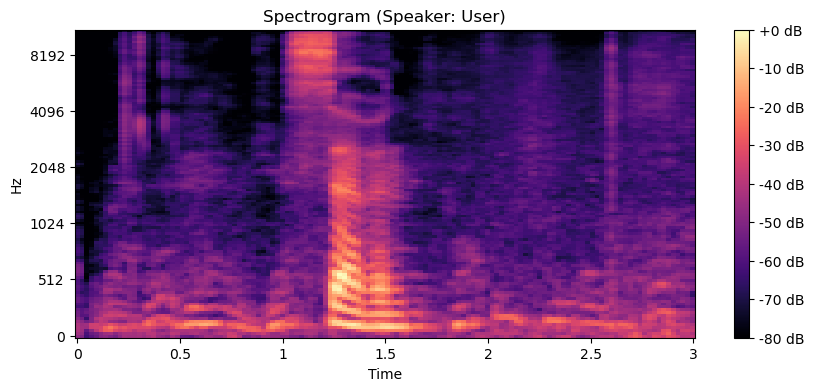

In [5]:
# User input to record

user_input = input('Would you like to record a number between 0 and 9? Enter y/n:')

assert user_input.lower() == 'y' or user_input.lower() == 'n', 'Please enter y or n'

if user_input.lower() == 'y':
    output_file = 'recorded_audio.wav'
    record_audio(output_file)
else:
    print('Run this cell again to record.')


In [6]:
# Convert wav file to tensor and output number using model

def wav_to_tensor(audio_path):
    audio, sr = librosa.load(audio_path)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram /= np.max(spectrogram)

    audio_tensor = tf.convert_to_tensor(spectrogram, dtype=tf.float32)
    audio_tensor = tf.expand_dims(audio_tensor, axis=-1)
    audio_tensor = tf.image.resize_with_crop_or_pad(audio_tensor, 128, 32)
    audio_tensor = tf.expand_dims(audio_tensor, axis=0)
    return audio_tensor

audio_path = os.getcwd() + '/recorded_audio.wav'
audio_tensor = wav_to_tensor(audio_path)

predictions = model.predict(audio_tensor)
predicted_label = tf.argmax(predictions, axis=1).numpy()
print("Predicted label:", predicted_label[0])

1/1 [==============================] - 0s 61ms/step
Predicted label: 7
